<a href="https://colab.research.google.com/github/ToanToan110/MarketResponseModel/blob/main/MarketResponseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Chuẩn bị dữ liệu:

In [ ]:
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
import plotly.graph_objs as go
# import plotly.plotly as py
import plotly.offline as pyoff

import warnings
warnings.filterwarnings("ignore")

Đã phân khúc được khách hàng và thực hiện một số chiến dịch tiếp cận đối tượng khách hàng cụ thể:

=>   Cần chọn ra chính sách có hiệu quả nhất về cả chi phí và tỉ lệ chuyển đổi



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Driven Growth Series/ConversionCustomer.csv")
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
df.groupby(['used_discount', 'used_bogo']).count()

recency  history  zip_code  is_referral  channel  \
used_discount used_bogo                                                     
0             1            28734    28734     28734        28734    28734   
1             0            28818    28818     28818        28818    28818   
              1             6448     6448      6448         6448     6448   

                         offer  conversion  
used_discount used_bogo                     
0             1          28734       28734  
1             0          28818       28818  
              1           6448        6448

**Giải thích bộ dữ liệu:**

Lần truy cập gần đây: tháng kể từ lần mua hàng cuối cùng

Lịch sử: $ giá trị của các lần mua trước đây

used_discount / used_bogo: cho biết liệu khách hàng đã sử dụng giảm giá hay mua một tặng một trước đó

zip_code: loại mã zip là để phân loại ngoại thành / thành thị / nông thôn

is_referral: cho biết liệu khách hàng có được mua lại từ kênh giới thiệu hay không

Kênh (channel): các kênh mà khách hàng sử dụng ( điện thoại / Web / đa kênh)

Ưu đãi: ưu đãi được gửi cho khách hàng ( giảm giá / mua một tặng một / không ưu đãi)

In [ ]:
# Tập dữ liệu mất cân bằng
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000




> **Nội dung của notebook**: Xây dựng mô hình phân loại để tìm ra đặc điểm chung của nhóm khách hàng chuyển đổi. Các bước thực hiện:

I. Xây dựng công thức tăng trưởng

II. Phân tích khám phá và rút trích đặc trưng

III. Tính toán xác suất chuyển đổi

IV. Kiểm tra trên tập test



# II. Xây dựng công thức tăng trưởng (Uplift Formula):

Uplift formula là công thức tính toán sự cải thiện của tỉ lệ chuyển đổi trong AB testing:

- **Conversion uplift**: Conversion rate of test group - conversion rate of control group

- **Order Uplift**: Conversion uplift * # converted customer in test group

- **Revenue Uplift**: Order Uplift * Average order $ value

In [ ]:
def calc_uplift(df):
    #assigning 25$ to the average order value
    avg_order_value = 25

    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()

    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv

    # calculate order uplift
    disc_order_uplift = disc_conv_uplift * df[df.offer == 'Discount']['conversion'].count()
    bogo_order_uplift = bogo_conv_uplift * df[df.offer == 'Buy One Get One']['conversion'].count()

    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value


    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))

    print('-------------- \n')
    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))
calc_uplift(df)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


=> Giảm giá (discount) là sự lựa chọn tốt hơn vì tỉ lệ chuyển đổi cao hơn (7.66%)

III. EDA

In [ ]:
import plotly.express as px

In [ ]:
df.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'offer', 'conversion'],
      dtype='object')

In [ ]:
# @title Tỉ lệ chuyển đổi theo thời điểm mua hàng gần nhất
df_rec = df.groupby('recency')['conversion'].mean().reset_index()
fig = px.bar(df_rec, x = 'recency', y='conversion', title = 'Avg conversion rate by recency')
fig.show()

=> Tỉ lệ chuyển đổi có dấu hiệu tăng lên nếu lần mua hàng gần nhất giảm xuống

In [ ]:
# @title Tỉ lệ chuyển đổi theo doanh số trong quá khứ
# Split the DataFrame into 5 quantiles
quantiles = pd.qcut(df['history'], q=5, labels=False)

# Add the quantile information as a new column to the DataFrame
x = pd.DataFrame()
x['Quantile'] = quantiles
x['conversion'] = df['conversion']


df_rec = x.groupby('Quantile')['conversion'].mean().reset_index()
fig = px.bar(df_rec, x = 'Quantile', y = 'conversion', title = 'Bar')

fig.show()

=> Khách hàng có doanh số cao thì cũng có khả năng chuyển đổi cao hơn

In [ ]:
# @title Tỉ lệ chuyển đổi theo zip code
df_rec = df.groupby('zip_code')['conversion'].mean().reset_index()
fig = px.bar(df_rec, x = 'zip_code', y='conversion', title = 'Avg conversion rate by zip_code')
fig.show()

=> Nông thôn là nôi có tỉ lệ chuyển đổi cao vượt trội.

In [ ]:
# @title Tỉ lệ chuyển đổi theo kênh bán hàng
df_rec = df.groupby('channel')['conversion'].mean().reset_index()
fig = px.bar(df_rec, x = 'channel', y='conversion', title = 'Avg conversion rate by channel')
fig.show()

=> Khách hàng đa kênh có tỉ lệ chuyển đổi cao hơn

In [ ]:
# @title Tỉ lệ chuyển đổi theo offer đề xuất với khách hàng
df_rec = df.groupby('offer')['conversion'].mean().reset_index()
fig = px.bar(df_rec, x = 'offer', y='conversion', title = 'Avg conversion rate by offer')
fig.show()

=> KHách hàng được giảm giá có tỉ lệ chuyển đổi cao hơn

In [ ]:

df.groupby(['used_discount','used_bogo','offer']).agg({'conversion':'mean'})

conversion
used_discount used_bogo offer                      
0             1         Buy One Get One    0.169794
                        Discount           0.166388
                        No Offer           0.095808
1             0         Buy One Get One    0.110892
                        Discount           0.168968
                        No Offer           0.099813
              1         Buy One Get One    0.251653
                        Discount           0.314993
                        No Offer           0.180549

# III. Xây dựng mô hình dự đoán conversion:

Dùng mohinh2 để dự đoán tỉ lệ conversion của từng khách hàng

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [ ]:
df_model = df.copy()
df_model = pd.get_dummies(df_model)
#create feature set and labels
X = df_model.drop(['conversion'],axis=1)
y = df_model['conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
xgb_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
X_test['proba'] = xgb_model.predict_proba(X_test)[:,1]
# X_test['y_pred'] = (X_test['proba'] > 0.5).astype(int)


In [ ]:
X_test.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer,proba
11277,3,466.66,0,1,1,False,False,True,False,True,False,False,True,False,0.130468
55819,8,44.25,0,1,0,False,False,True,False,True,False,True,False,False,0.269786
43223,10,370.84,0,1,0,False,False,True,False,True,False,False,True,False,0.216247
1351,3,114.27,1,0,1,False,False,True,False,False,True,False,True,False,0.104526
9247,5,230.93,1,1,0,False,True,False,False,True,False,False,False,True,0.081479


In [ ]:
# @title Đánh giá mô hình
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92     16431
           1       0.22      0.01      0.02      2769

    accuracy                           0.85     19200
   macro avg       0.54      0.50      0.47     19200
weighted avg       0.76      0.85      0.79     19200



In [ ]:
X_test['conversion'] = y_test
real_disc_uptick = X_test[X_test['offer_Discount'] == 1].conversion.mean() - X_test[X_test['offer_No Offer'] == 1].conversion.mean()

pred_disc_uptick = X_test[X_test['offer_Discount'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean()
print(real_disc_uptick)
print(pred_disc_uptick)

0.07006748831696787
0.07798157


In [ ]:
X_test['conversion'] = y_test
real_disc_uptick = X_test[X_test['offer_Buy One Get One'] == 1].conversion.mean() - X_test[X_test['offer_No Offer'] == 1].conversion.mean()

pred_disc_uptick = X_test[X_test['offer_Buy One Get One'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean()
print(real_disc_uptick)
print(pred_disc_uptick)

0.04521810911351966
0.043095656


=> Mô hình dự báo tốt được tỉ lệ conversion chung của các loại offer


# IV. Xác định đối tượng cần áp dụng khuyến mãi
> Sau khui đã xây dựng mô hình và đánh giá được tỉ lệ chuyển đổi trên toàn bộ khách hàng, câu hỏi đặt ra là liệu chúng ta có cần thực hiện khuyến mãi trên toàn bộ khách hàng hay không ? Câu trà lời là không, có 4 nhóm khách hàng chính mà ta sẽ tiếp cận như sau:
- **Treatment Responders:** Những khách hàng sẽ chỉ mua chỉ khi họ được nhận khuyến mãi
- **Treatment Non-Responders:** Những khách hàng sẽ không bao giờ mua hàng
- **Control Responders:** Những khách hàng sẽ mua cho dù không có khuyến mãi
- **Control Non-Responders:** Những khách hàng sẽ không mua nếu họ không nhận được khuyến mãi

=> Rõ ràng, Chúng ta cần tập trung vào đối tượng Treatment Responders (TR) và Control Non-Responders (CN)

=> Ý tưởng mô hình, tính toán xác suất rơi vào 4 nhóm của từng khách hàng, sau đó tính toán tăng trưởng dựa trên công thức sau:

`Uplift = p(TR) + p(CN) - p(CR) - p(TN)`


=> Uplift càng cao thì khả năng quay chuyển đổi càng cao nếu áp dụng khuyến mãi.

In [ ]:
# df['TR'] = df['CN'] = df['CR'] = df['TN'] = 0
df['target_class'] = 0
df.loc[(df['conversion'] == 1) & (df['offer'] != "No Offer"), 'target_class'] = 3 #TR
df.loc[(df['conversion'] == 0) & (df['offer'] != "No Offer"), 'target_class'] = 2 #TN
df.loc[(df['conversion'] == 1) & (df['offer'] == "No Offer"), 'target_class'] = 1 #CR
df.loc[(df['conversion'] == 0) & (df['offer'] == "No Offer"), 'target_class'] = 0 #CN
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,target_class
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,2
1,6,329.08,1,1,Rural,1,Web,No Offer,0,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,2
3,9,675.83,1,0,Rural,1,Web,Discount,0,2
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,2


In [ ]:
# from sklearn.cluster import KMeans
# def order_cluster(cluster_field_name, target_field_name,df,ascending):
#     new_cluster_field_name = 'new_' + cluster_field_name
#     df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
#     df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
#     df_new['index'] = df_new.index
#     df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
#     df_final = df_final.drop([cluster_field_name],axis=1)
#     df_final = df_final.rename(columns={"index":cluster_field_name})
#     return df_final
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(df[['history']])
# df['history_cluster'] = kmeans.predict(df[['history']])
# df = order_cluster('history_cluster', 'history',df,True)
# df

## Xây dựng mô hình dự đoán nhóm:

In [ ]:
#creating a new dataframe as model and dropping columns that defines the label
df_model = df.drop(['offer','conversion'],axis=1)
#convert categorical columns
df_model = pd.get_dummies(df_model)
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,target_class,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,2,False,True,False,False,True,False
1,6,329.08,1,1,1,0,True,False,False,False,False,True
2,7,180.65,0,1,1,2,False,True,False,False,False,True
3,9,675.83,1,0,1,2,True,False,False,False,False,True
4,2,45.34,1,0,0,2,False,False,True,False,False,True


In [ ]:
import xgboost as xgb
X = df_model.drop(['target_class'], axis = 1)
y = df.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

In [ ]:
class_probs[0]

array([0.23495738, 0.13031568, 0.4519928 , 0.1827341 ], dtype=float32)

In [ ]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(X)
overall_proba

array([[0.331452  , 0.02444906, 0.5926381 , 0.05146083],
       [0.13835554, 0.05414621, 0.6490042 , 0.15849406],
       [0.26945972, 0.01763701, 0.60613567, 0.10676762],
       ...,
       [0.31288683, 0.00648346, 0.6447304 , 0.03589934],
       [0.33325255, 0.02007597, 0.56207037, 0.08460114],
       [0.20552225, 0.07629882, 0.50699985, 0.21117905]], dtype=float32)

In [ ]:
#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0]
df_model['proba_CR'] = overall_proba[:,1]
df_model['proba_TN'] = overall_proba[:,2]
df_model['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')
#assign it back to main dataframe
df['uplift_score'] = df_model['uplift_score']
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,target_class,uplift_score
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,2,-0.234174
1,6,329.08,1,1,Rural,1,Web,No Offer,0,0,-0.406301
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,2,-0.247545
3,9,675.83,1,0,Rural,1,Web,Discount,0,2,-0.417600
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,2,-0.170204


## Đánh giá kết quả:
Để dánh giá mô hình, ta cần tạo một benchmark như sau:
1. High uplift score: Khách hàng có uplift score > khoảng phân vị thứ 3
1. Low uplift score: Khách hàng có uplift score < khoảng phân vị thứ 2

In [ ]:
df_data_lift = df.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[df_data_lift.uplift_score > uplift_q_75].reset_index(drop=True)
calc_uplift(df_data_lift)

Discount Conversion Uplift: 27.09%
Discount Order Uplift: 1213.11
Discount Revenue Uplift: $30327.7

-------------- 

BOGO Conversion Uplift: 21.76%
BOGO Order Uplift: 953.25
BOGO Revenue Uplift: $23831.35


**Nhận xét:**

- Discount mang lại tỉ lệ chuyển đôi 27.09%, cao hơn đáng kể so với Buy one Get One

=> Tương đương với khoảng 1213 khách hàng sẽ chuyển đổi với doanh thu tăng têm khoảng 30 nghìn đô

Danh sách những khách hàng có thể tập trung vào

In [ ]:
result = df_data_lift.loc[df_data_lift['conversion'] == 0]

Tổng là 12,654 khách hàng cần tập trung vào chạy khuyển mãi.

In [ ]:
result

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,target_class,uplift_score
2,4,241.42,0,1,Rural,1,Multichannel,No Offer,0,0,0.045538
3,11,219.04,1,1,Surburban,0,Phone,Discount,0,2,0.450856
5,4,78.24,1,0,Surburban,0,Web,No Offer,0,0,-0.087967
7,7,435.73,0,1,Urban,1,Web,No Offer,0,0,-0.087549
8,2,203.35,1,0,Rural,0,Web,No Offer,0,0,-0.054890
...,...,...,...,...,...,...,...,...,...,...,...
15993,3,67.78,0,1,Surburban,0,Web,Buy One Get One,0,2,0.006648
15994,5,549.87,0,1,Surburban,1,Phone,Buy One Get One,0,2,-0.070764
15995,1,710.72,1,1,Urban,1,Phone,No Offer,0,0,0.178957
15996,10,168.21,0,1,Surburban,0,Phone,No Offer,0,0,0.121997


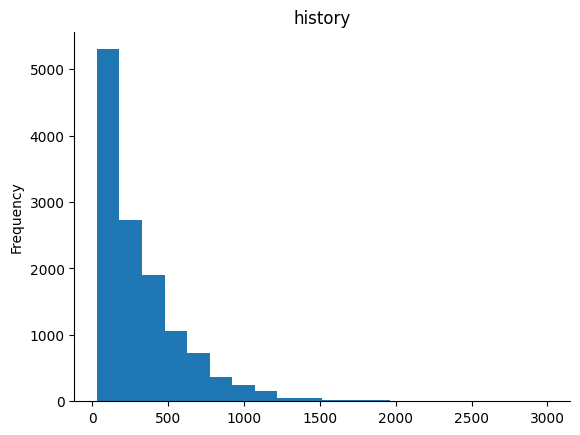

In [ ]:
from matplotlib import pyplot as plt
result['history'].plot(kind='hist', bins=20, title='history')
plt.gca().spines[['top', 'right',]].set_visible(False)

=> Đa sô tập trung vào khách hàng có doanh số thấp trong quá khứ

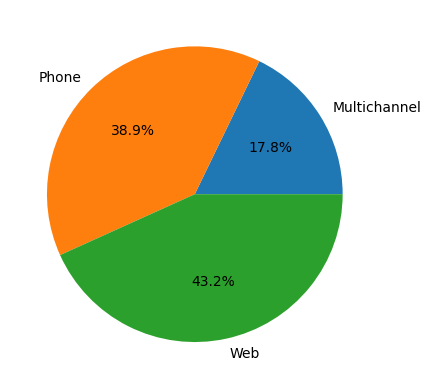

In [ ]:
df_pie = result.groupby('channel')['recency'].count().reset_index()
plt.pie(df_pie['recency'], labels = df_pie['channel'],autopct='%1.1f%%')
plt.show()

=> Hạn chế tập trung vào các khách hàng sử dụng dịch vụ đa kênh